In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import os, glob
import torch

from models.main import build_network
from preprocess import get_data

In [2]:
class Args:
    model='vae'
    r='./experiments'
    lr=0.001
    z_dim=32
    in_dim=152
    data_pth='../data'
    batch_size=128
    outlier='none'
    hierClass='Transient'
    fold=0

args = Args()
if args.outlier!='none':
    job_name = '{}_{}_{}_lr{}_ld{}_fold{}'.format(args.model, args.hierClass, args.outlier, 
                                                  args.lr, args.z_dim, args.fold)
else:
    job_name = '{}_{}_lr{}_ld{}_fold{}'.format(args.model, args.hierClass, args.lr, 
                                               args.z_dim, args.fold)
args.directory = os.path.join(args.r, job_name)

### Learning curves

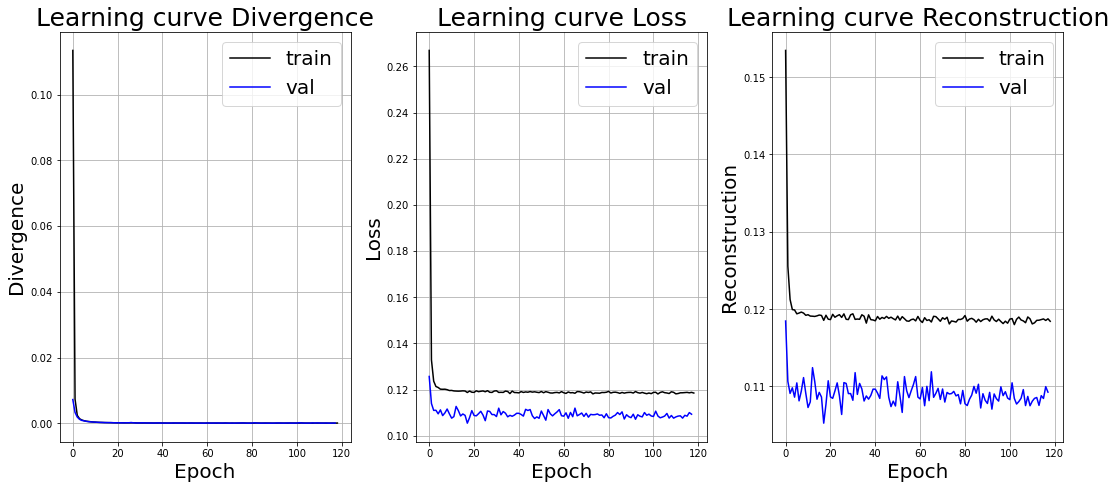

In [3]:
from utils.plots import plot_event

event = glob.glob(os.path.join(args.directory, 'event*'))
plot_event(event)

### Analyzing latent space.

In [4]:
# train, val, test
_, _, dataloader = get_data(args)

GP_DRW_tau_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Pvar_1


In [5]:
model_pth = os.path.join(args.directory, 'trained_parameters.pth')
state_dict = torch.load(model_pth)
model = build_network(args)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
zs = []
xrec = []
xreal = []
lbls_out = []
lbls_class = []
for _, x, lbl_class, lbl_out in dataloader:
    with torch.no_grad():
        model.eval()
        x = x.float()

        mu, log_var, z, x_hat = model(x)
        zs.append(z)
        xrec.append(x_hat)
        xreal.append(x)
        lbls_out.append(lbl_out)
        lbls_class.append(lbl_class)
zs = torch.cat(zs).numpy()
xrec = torch.cat(xrec).numpy()
xreal = torch.cat(xreal).numpy()
lbls_out = torch.cat(lbls_out).numpy()
lbls_class = torch.cat(lbls_class).numpy()

In [7]:
from sklearn.manifold import TSNE
import numpy as np 

x_embedded = TSNE(n_components=2).fit_transform(zs)

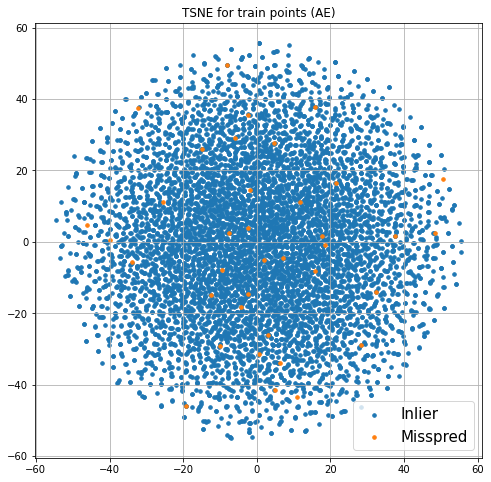

In [8]:
dict_classes = {0: 'Inlier',
                1: 'Misspred',
                2: 'Outlier',
    
}

plt.figure(figsize=(8,8))
plt.title('TSNE for train points (AE)')
for key in range(len(np.unique(lbls_out))):
    plt.scatter(x_embedded[:, 0][lbls_out==key], x_embedded[:, 1][lbls_out==key], 
                s=50, alpha=1, marker='.', label=dict_classes[key])
plt.legend(fontsize=15)
plt.grid(True)

## Analyzing reconstructions.

In [9]:
feature_list_pth='../data_raw/features_RF_model.pkl'
feature_list = pd.read_pickle(feature_list_pth)
feature_list

# Some important features
important_features = [
'W1-W2',
'sgscore1',
'positive_fraction_2',
'positive_fraction_1',
'SPM_tau_rise_1',
'LinearTrend_2', 
'SPM_chi_1', 
'g-W2', 
'g-W3', 
'n_non_det_after_fid_2',
'W2-W3',
'SPM_beta_1',
'SPM_tau_rise_2',
'SPM_A_2',
'IAR_phi_1',
'IAR_phi_2',
]

In [10]:
def update(handle, orig):
    handle.update_from(orig)
    handle.set_alpha(1)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Attempting to set identical bottom == top == 0.46211716532707214 results in singular transformations; automatically expanding.
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Attempting to set identical left == right == 0.46211716532707214 results in singular transformations; automatically expanding.


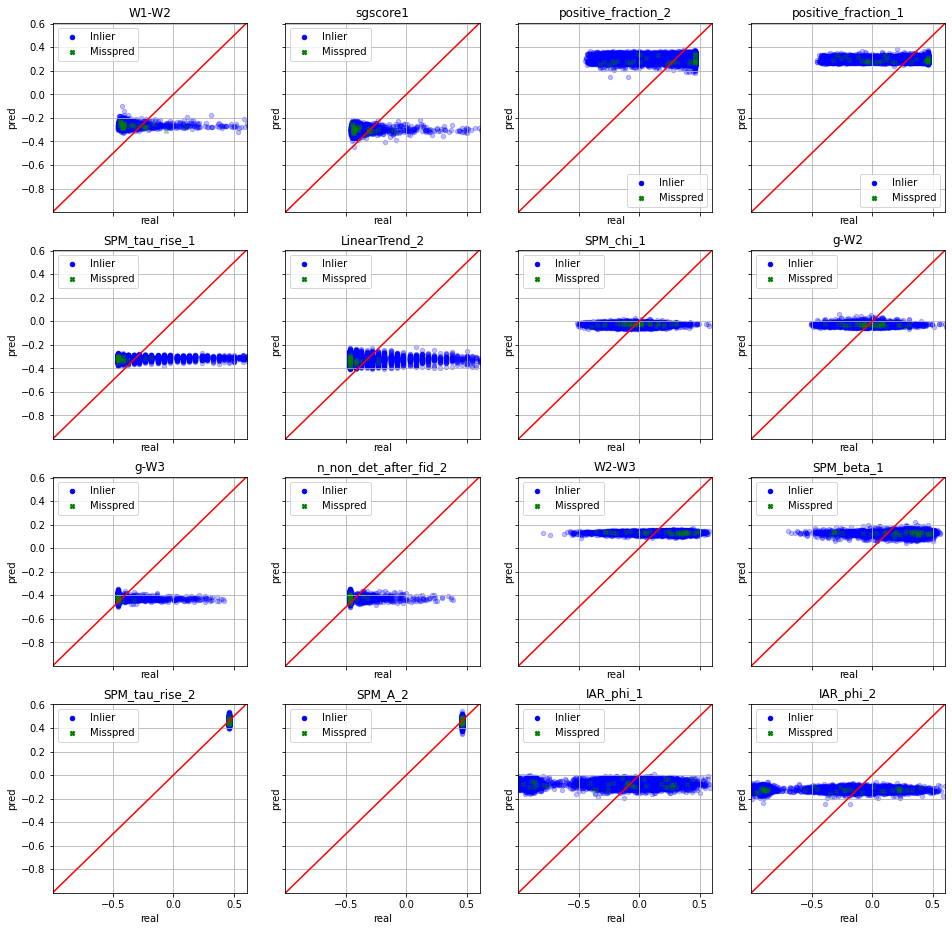

In [11]:
from matplotlib.collections import PathCollection
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D

f, ax = plt.subplots(nrows=4, ncols=4, figsize=(16,16), sharey=True, sharex=True)

colors = {0: ('b', 'o'), #inlier
          1: ('g', 'X'), #misspred
          2: ('red', '*'), #outlier
}

ident = [-1.0, 1.0]
for i, feature in enumerate(important_features):
    ix = important_features.index(feature)
    ax[i//4, i%4].set_title(feature)
    for key in range(len(np.unique(lbls_out))):
        ax[i//4, i%4].scatter(xreal[:,ix][lbls_out==key], xrec[:,ix][lbls_out==key], 
                              label=dict_classes[key], s=20, alpha=0.25, c=colors[key][0],
                              marker=colors[key][1])
    ax[i//4, i%4].plot(ident, ident, c='r')
    ax[i//4, i%4].set_ylim(np.min(xreal[:,ix]), np.max(xreal[:,ix]))
    ax[i//4, i%4].set_xlim(np.min(xreal[:,ix]), np.max(xreal[:,ix]))
    ax[i//4, i%4].set_xlabel('real')
    ax[i//4, i%4].set_ylabel('pred')
    ax[i//4, i%4].grid()
    ax[i//4, i%4].legend(loc='best', handler_map={PathCollection : HandlerPathCollection(update_func= update),
                         plt.Line2D : HandlerLine2D(update_func = update)})
plt.show()

### Analizing scores

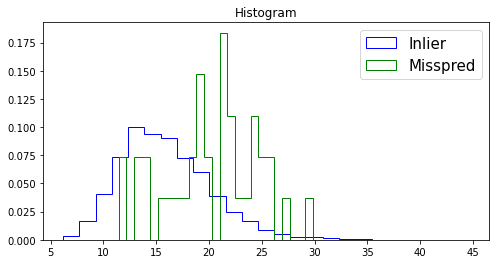

In [12]:
scores = np.sum((xrec - xreal)**2, axis=1)

plt.figure(figsize=(8,4))
plt.title('Histogram')
for key in range(len(np.unique(lbls_out))):
    plt.hist(scores[lbls_out==key], label=dict_classes[key], bins=25, 
             density=True, histtype='step', color=colors[key][0])
plt.legend(fontsize=15)

### Report metrics

In [13]:
from sklearn.metrics import auc

def auroc(in_scores, out_scores):
    scores = np.concatenate((in_scores, out_scores), axis=0)
    start = np.min(scores)
    end = np.max(scores)   
    gap = (end - start)/100000

    aurocBase = 0.0
    fprTemp = 1.0
    tprs = []
    fprs = []

    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(out_scores > delta)) / len(scores)
        fpr = np.sum(np.sum(in_scores > delta)) / len(in_scores)
        tprs.append(tpr)
        fprs.append(fpr)
    return auc(fprs, tprs), fprs, tprs

def aupr(in_scores, out_scores):
    scores = np.concatenate((in_scores, out_scores), axis=0)
    start = np.min(scores)
    end = np.max(scores)   
    gap = (end - start)/100000

    precisions = []
    recalls = []
    for delta in np.arange(start, end, gap):
        tp = np.sum(np.sum(out_scores > delta))
        fp = np.sum(np.sum(in_scores > delta))
        if tp + fp == 0: continue
        precision = tp / (tp + fp)
        recall = tp / np.float(len(out_scores))
        precisions.append(precision)
        recalls.append(recall)
    auc(recalls, precisions)
    return auc(recalls, precisions), recalls, precisions

In [14]:
in_scores = scores[lbls_out==0]
out_scores = scores[(lbls_out==1) | (lbls_out==2)]
auroc_score, fprs, tprs = auroc(in_scores, out_scores)
aupr_score, recalls, precisions = aupr(in_scores, out_scores)
'AUROC {} AUPR {}'.format(auroc_score, aupr_score)

'AUROC 0.0037723459276959035 AUPR\xa00.016135977519844042'

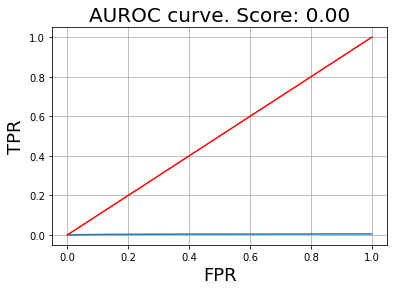

In [15]:
ident=[0.0, 1.0]
plt.title('AUROC curve. Score: {:.2f}'.format(auroc_score), fontsize=20)
plt.plot(fprs, tprs)
plt.plot(ident, ident, c='r')
plt.xlabel('FPR', fontsize=18)
plt.ylabel('TPR', fontsize=18)
plt.grid()

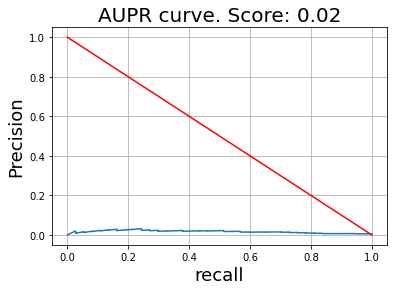

In [16]:
ident=[[0, 1], [1, 0]]
plt.title('AUPR curve. Score: {:.2f}'.format(aupr_score), fontsize=20)
plt.plot(recalls, precisions)
plt.plot(ident[0], ident[1], c='r')
plt.xlabel('recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.grid()